### Επίδραση του Αριθμού των Δωρεάν Αδειών στα Κέρδη και άλλες Μεταβλητές των Επιχειρήσεων

**Πείραμα:**
- Emission cap = 70%, 80%, 90% BAU emissions
- 9 εταιρείες
- 3 τομείς
  - Ο 3ος τομέας έχει **πολύ μεγάλο** μέγεθος σε όρους πωλήσεων

**Διαδικασία:**
Δίνουμε σταδιακά περισσότερες δωρεάν άδειες σε όλους και το συγκρίνουμε με το να έπαιρνε δωρεάν μόνο ο πρώτος τομέας.

- Δωρεάν άδειες: από 0 έως την ποσότητα παραγωγής (q).


In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
from random import random


In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator24 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator24)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator24)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator24)
country1 = Country('DE', 1, regulator= Regulator24)
country2 = Country('FI', 0.5, regulator= Regulator24)
country3 = Country('GR', size= 0.1, regulator= Regulator24)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator24)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator24)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator24)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator24)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator24)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator24)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator24)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator24)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator24)



In [3]:
Regulator24.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
# Define the doentages of BAU emissions
do_all_get_free = [False, True]
percentage_of_emission_cap = 0.8
Regulator24.emission_cap = Regulator24.BAU_emissions * percentage_of_emission_cap
# Initialize dictionaries to store results for each doentage
results = {do: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'trades1': [], 'trades2': [], 'permits_bought_1': [], 'permits_bought_2': [],
    'permits_free_1': [], 'permits_free_2': [], 'permits_used_1': [], 'permits_used_2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': [],
    'consumer_surplus_1' : [], 'consumer_surplus_2' : []
} for do in do_all_get_free}

# Loop over each doentage
for do in do_all_get_free:
    Regulator24.emission_cap = Regulator24.BAU_emissions * 0.8
    frees = np.linspace(0, 1, 100)

    for free in tqdm.tqdm(frees):
        sector1.free_emission_multiplier = free
        if do:
            sector2.free_emission_multiplier = free
            sector3.free_emission_multiplier = free
        Regulator24.optimization_concave_formulation_ab()
        print(f"{free}: {Regulator24.equilibrium_tester(precision= 0.1, output=True)}")

        for firm in Regulator24.firm_registry.values():
            firm.calculate_profit_components()

        results[do]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[do]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[do]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[do]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[do]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[do]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[do]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[do]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[do]['permit_price'].append(Regulator24.permit_price)
        results[do]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[do]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[do]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[do]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))
        results[do]['consumer_surplus_1'].append(sector1.get_consumer_surplus())
        results[do]['consumer_surplus_2'].append((sector2.get_consumer_surplus() + sector3.get_consumer_surplus())/2)
        results[do]['permits_used_1'].append(mean( float(i.permits_used) for i in sector1.firms))
        results[do]['permits_used_2'].append(mean( float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[do]['permits_free_1'].append(mean( float(i.free_permits) for i in sector1.firms))
        results[do]['permits_free_2'].append(mean( float(i.free_permits) for i in sector2.firms + sector3.firms))
        results[do]['permits_bought_1'].append(mean( float(i.permits_bought) for i in sector1.firms))
        results[do]['permits_bought_2'].append(mean( float(i.permits_bought) for i in sector2.firms + sector3.firms))




  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<06:11,  3.75s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ✔️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 5/5
0.0: (True, 0.0818096217198594)
Optimal solution found


  2%|▏         | 2/100 [00:07<05:46,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0807 ✔️ | +7.06e-10 ✔️ |  -24.6916 ✔️ |  -24.8916 ✔️ |   +4.9383 ✔️ | 5/5
0.010101010101010102: (True, 0.0807269046906871)
Optimal solution found


  3%|▎         | 3/100 [00:10<05:37,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0796 ✔️ |  +2.81e-5 ✔️ |  -24.7521 ✔️ |  -24.9521 ✔️ |   +4.9504 ✔️ | 5/5
0.020202020202020204: (True, 0.0796139146075401)
Optimal solution found


  4%|▍         | 4/100 [00:14<05:41,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0785 ✔️ |  +2.85e-5 ✔️ |  -24.8130 ✔️ |  -25.0130 ✔️ |   +4.9626 ✔️ | 5/5
0.030303030303030304: (True, 0.0784845602435205)
Optimal solution found


  5%|▌         | 5/100 [00:17<05:31,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0773 ✔️ |  +1.72e-5 ✔️ |  -24.8743 ✔️ |  -25.0743 ✔️ |   +4.9749 ✔️ | 5/5
0.04040404040404041: (True, 0.0773402624920294)
Optimal solution found


  6%|▌         | 6/100 [00:21<05:31,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0762 ✔️ |  +3.19e-5 ✔️ |  -24.9360 ✔️ |  -25.1360 ✔️ |   +4.9872 ✔️ | 5/5
0.05050505050505051: (True, 0.0761657191229528)
Optimal solution found


  7%|▋         | 7/100 [00:24<05:25,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0749 ✔️ |  +8.37e-6 ✔️ |  -24.9982 ✔️ |  -25.1982 ✔️ |   +4.9996 ✔️ | 5/5
0.06060606060606061: (True, 0.0749152819695897)
Optimal solution found


  8%|▊         | 8/100 [00:27<05:07,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0737 ✔️ |  +2.86e-5 ✔️ |  -25.0607 ✔️ |  -25.2607 ✔️ |   +5.0121 ✔️ | 5/5
0.07070707070707072: (True, 0.0736942570477890)
Optimal solution found


  9%|▉         | 9/100 [00:30<04:56,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0724 ✔️ |  +1.32e-5 ✔️ |  -25.1238 ✔️ |  -25.3238 ✔️ |   +5.0248 ✔️ | 5/5
0.08080808080808081: (True, 0.0723903255943785)
Optimal solution found


 10%|█         | 10/100 [00:33<04:51,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0711 ✔️ |  +1.40e-5 ✔️ |  -25.1873 ✔️ |  -25.3873 ✔️ |   +5.0375 ✔️ | 5/5
0.09090909090909091: (True, 0.0710829946066980)
Optimal solution found


 11%|█         | 11/100 [00:38<05:12,  3.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0697 ✔️ |  +2.42e-6 ✔️ |  -25.2512 ✔️ |  -25.4512 ✔️ |   +5.0502 ✔️ | 5/5
0.10101010101010102: (True, 0.0697465447155583)
Optimal solution found


 12%|█▏        | 12/100 [00:41<04:57,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0702 ✔️ |  +9.75e-6 ✔️ |  -25.3156 ✔️ |  -25.5156 ✔️ |   +5.0631 ✔️ | 5/5
0.11111111111111112: (True, 0.0702134102928653)
Optimal solution found


 13%|█▎        | 13/100 [00:44<04:49,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0670 ✔️ |  +2.82e-5 ✔️ |  -25.3804 ✔️ |  -25.5804 ✔️ |   +5.0761 ✔️ | 5/5
0.12121212121212122: (True, 0.0669699541455540)
Optimal solution found


 14%|█▍        | 14/100 [00:47<04:38,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0655 ✔️ |  +1.31e-5 ✔️ |  -25.4458 ✔️ |  -25.6458 ✔️ |   +5.0892 ✔️ | 5/5
0.13131313131313133: (True, 0.0655322198906347)
Optimal solution found


 15%|█▌        | 15/100 [00:50<04:34,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0641 ✔️ |  +1.03e-5 ✔️ |  -25.5116 ✔️ |  -25.7116 ✔️ |   +5.1023 ✔️ | 5/5
0.14141414141414144: (True, 0.0640611419010906)
Optimal solution found


 16%|█▌        | 16/100 [00:54<04:41,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0626 ✔️ |  +2.09e-5 ✔️ |  -25.5778 ✔️ |  -25.7778 ✔️ |   +5.1156 ✔️ | 5/5
0.15151515151515152: (True, 0.0625751491070705)
Optimal solution found


 17%|█▋        | 17/100 [00:56<04:24,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0610 ✔️ |  +1.23e-5 ✔️ |  -25.6446 ✔️ |  -25.8446 ✔️ |   +5.1289 ✔️ | 5/5
0.16161616161616163: (True, 0.0610113237709111)
Optimal solution found


 18%|█▊        | 18/100 [00:59<04:15,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0594 ✔️ |  +1.19e-5 ✔️ |  -25.7118 ✔️ |  -25.9118 ✔️ |   +5.1424 ✔️ | 5/5
0.17171717171717174: (True, 0.0594233948186904)
Optimal solution found


 19%|█▉        | 19/100 [01:03<04:12,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0590 ✔️ |  +1.77e-5 ✔️ |  -25.7796 ✔️ |  -25.9796 ✔️ |   +5.1559 ✔️ | 5/5
0.18181818181818182: (True, 0.0589643910456523)
Optimal solution found


 20%|██        | 20/100 [01:06<04:15,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0562 ✔️ |  +8.63e-6 ✔️ |  -25.8478 ✔️ |  -26.0478 ✔️ |   +5.1696 ✔️ | 5/5
0.19191919191919193: (True, 0.0561552280225328)
Optimal solution found


 21%|██        | 21/100 [01:09<04:18,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0545 ✔️ |  +3.36e-6 ✔️ |  -25.9166 ✔️ |  -26.1166 ✔️ |   +5.1833 ✔️ | 5/5
0.20202020202020204: (True, 0.0544632699905154)
Optimal solution found


 22%|██▏       | 22/100 [01:13<04:15,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0527 ✔️ |  +4.78e-6 ✔️ |  -25.9859 ✔️ |  -26.1859 ✔️ |   +5.1972 ✔️ | 5/5
0.21212121212121213: (True, 0.0527282912955300)
Optimal solution found


 23%|██▎       | 23/100 [01:16<04:05,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0510 ✔️ |  +2.57e-5 ✔️ |  -26.0557 ✔️ |  -26.2557 ✔️ |   +5.2111 ✔️ | 5/5
0.22222222222222224: (True, 0.0509717972448289)
Optimal solution found


 24%|██▍       | 24/100 [01:19<04:08,  3.27s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0491 ✔️ |  +3.36e-6 ✔️ |  -26.1260 ✔️ |  -26.3260 ✔️ |   +5.2252 ✔️ | 5/5
0.23232323232323235: (True, 0.0491258205238516)
Optimal solution found


 25%|██▌       | 25/100 [01:22<04:06,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ✔️ |  +2.28e-5 ✔️ |  -26.1968 ✔️ |  -26.3968 ✔️ |   +5.2394 ✔️ | 5/5
0.24242424242424243: (True, 0.0472594883288089)
Optimal solution found


 26%|██▌       | 26/100 [01:26<04:03,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ✔️ |  +1.74e-5 ✔️ |  -26.2683 ✔️ |  -26.4683 ✔️ |   +5.2537 ✔️ | 5/5
0.25252525252525254: (True, 0.0453664495319543)
Optimal solution found


 27%|██▋       | 27/100 [01:29<04:09,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0434 ✔️ |  +2.48e-5 ✔️ |  -26.3402 ✔️ |  -26.5402 ✔️ |   +5.2680 ✔️ | 5/5
0.26262626262626265: (True, 0.0433936880535342)
Optimal solution found


 28%|██▊       | 28/100 [01:33<04:01,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0414 ✔️ |  +2.33e-5 ✔️ |  -26.4127 ✔️ |  -26.6127 ✔️ |   +5.2825 ✔️ | 5/5
0.27272727272727276: (True, 0.0414128662837872)
Optimal solution found


 29%|██▉       | 29/100 [01:36<04:01,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0393 ✔️ |  +8.68e-6 ✔️ |  -26.4858 ✔️ |  -26.6858 ✔️ |   +5.2972 ✔️ | 5/5
0.2828282828282829: (True, 0.0393381726361230)
Optimal solution found


 30%|███       | 30/100 [01:40<04:14,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0372 ✔️ |  +8.94e-6 ✔️ |  -26.5595 ✔️ |  -26.7595 ✔️ |   +5.3119 ✔️ | 5/5
0.29292929292929293: (True, 0.0372452884647760)
Optimal solution found


 31%|███       | 31/100 [01:43<03:57,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0351 ✔️ |  +2.98e-5 ✔️ |  -26.6337 ✔️ |  -26.8337 ✔️ |   +5.3267 ✔️ | 5/5
0.30303030303030304: (True, 0.0350793597986527)
Optimal solution found


 32%|███▏      | 32/100 [01:47<03:49,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0329 ✔️ |  +2.76e-5 ✔️ |  -26.7085 ✔️ |  -26.9085 ✔️ |   +5.3417 ✔️ | 5/5
0.31313131313131315: (True, 0.0329077299724521)
Optimal solution found


 33%|███▎      | 33/100 [01:50<03:53,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0306 ✔️ |  +3.19e-5 ✔️ |  -26.7839 ✔️ |  -26.9839 ✔️ |   +5.3568 ✔️ | 5/5
0.32323232323232326: (True, 0.0306210882613449)
Optimal solution found


 34%|███▍      | 34/100 [01:54<03:50,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ✔️ |  +3.05e-5 ✔️ |  -26.8600 ✔️ |  -27.0600 ✔️ |   +5.3720 ✔️ | 5/5
0.33333333333333337: (True, 0.0283030306691430)
Optimal solution found


 35%|███▌      | 35/100 [01:57<03:41,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0259 ✔️ |  +2.10e-5 ✔️ |  -26.9366 ✔️ |  -27.1366 ✔️ |   +5.3873 ✔️ | 5/5
0.3434343434343435: (True, 0.0259382442449567)
Optimal solution found


 36%|███▌      | 36/100 [02:00<03:33,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0235 ✔️ |  +6.74e-6 ✔️ |  -27.0139 ✔️ |  -27.2139 ✔️ |   +5.4028 ✔️ | 5/5
0.3535353535353536: (True, 0.0235115657307521)
Optimal solution found


 37%|███▋      | 37/100 [02:04<03:31,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0211 ✔️ |  +2.90e-5 ✔️ |  -27.0917 ✔️ |  -27.2917 ✔️ |   +5.4183 ✔️ | 5/5
0.36363636363636365: (True, 0.0210534810556133)
Optimal solution found


 38%|███▊      | 38/100 [02:07<03:26,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0185 ✔️ |  +1.05e-5 ✔️ |  -27.1703 ✔️ |  -27.3703 ✔️ |   +5.4341 ✔️ | 5/5
0.37373737373737376: (True, 0.0184863019321764)
Optimal solution found


 39%|███▉      | 39/100 [02:11<03:35,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ✔️ |  +1.17e-6 ✔️ |  -27.2494 ✔️ |  -27.4494 ✔️ |   +5.4499 ✔️ | 5/5
0.38383838383838387: (True, 0.0158668161047224)
Optimal solution found


 40%|████      | 40/100 [02:14<03:30,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0132 ✔️ |  +1.51e-5 ✔️ |  -27.3293 ✔️ |  -27.5293 ✔️ |   +5.4659 ✔️ | 5/5
0.393939393939394: (True, 0.0131902783771025)
Optimal solution found


 41%|████      | 41/100 [02:18<03:30,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0105 ✔️ |  +1.97e-5 ✔️ |  -27.4098 ✔️ |  -27.6098 ✔️ |   +5.4820 ✔️ | 5/5
0.4040404040404041: (True, 0.0104693934107143)
Optimal solution found


 42%|████▏     | 42/100 [02:22<03:25,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0076 ✔️ |  +2.13e-5 ✔️ |  -27.4909 ✔️ |  -27.6909 ✔️ |   +5.4982 ✔️ | 5/5
0.4141414141414142: (True, 0.00764050780952807)
Optimal solution found


 43%|████▎     | 43/100 [02:25<03:21,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0048 ✔️ |  +2.15e-5 ✔️ |  -27.5728 ✔️ |  -27.7728 ✔️ |   +5.5146 ✔️ | 5/5
0.42424242424242425: (True, 0.00476219225029340)
Optimal solution found


 44%|████▍     | 44/100 [02:28<03:14,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0018 ✔️ |  +3.02e-6 ✔️ |  -27.6553 ✔️ |  -27.8553 ✔️ |   +5.5311 ✔️ | 5/5
0.43434343434343436: (True, 0.00181130767669302)
Optimal solution found


 45%|████▌     | 45/100 [02:32<03:17,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0012 ✔️ |  +3.66e-6 ✔️ |  -27.7386 ✔️ |  -27.9386 ✔️ |   +5.5477 ✔️ | 5/5
0.4444444444444445: (True, 0.00121490839961247)
Optimal solution found


 46%|████▌     | 46/100 [02:36<03:10,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0043 ✔️ |  +2.68e-5 ✔️ |  -27.8225 ✔️ |  -28.0225 ✔️ |   +5.5645 ✔️ | 5/5
0.4545454545454546: (True, 0.00433698378764547)
Optimal solution found


 47%|████▋     | 47/100 [02:39<02:59,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0075 ✔️ |  +2.77e-5 ✔️ |  -27.9072 ✔️ |  -28.1072 ✔️ |   +5.5814 ✔️ | 5/5
0.4646464646464647: (True, 0.00751431973146666)
Optimal solution found


 48%|████▊     | 48/100 [02:43<03:04,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0107 ✔️ |  +2.34e-5 ✔️ |  -27.9926 ✔️ |  -28.1926 ✔️ |   +5.5985 ✔️ | 5/5
0.4747474747474748: (True, 0.0107369641662132)
Optimal solution found


 49%|████▉     | 49/100 [02:46<03:05,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0141 ✔️ |  +7.82e-6 ✔️ |  -28.0788 ✔️ |  -28.2788 ✔️ |   +5.6158 ✔️ | 5/5
0.48484848484848486: (True, 0.0140892377184176)
Optimal solution found


 50%|█████     | 50/100 [02:50<02:56,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0175 ✔️ |  +2.19e-6 ✔️ |  -28.1657 ✔️ |  -28.3657 ✔️ |   +5.6331 ✔️ | 5/5
0.494949494949495: (True, 0.0175047631475849)
Optimal solution found


 51%|█████     | 51/100 [02:54<02:56,  3.61s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0210 ✔️ |  +2.41e-5 ✔️ |  -28.2534 ✔️ |  -28.4534 ✔️ |   +5.6507 ✔️ | 5/5
0.5050505050505051: (True, 0.0210120034483161)
Optimal solution found


 52%|█████▏    | 52/100 [02:57<02:46,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0246 ✔️ |  +2.83e-6 ✔️ |  -28.3419 ✔️ |  -28.5419 ✔️ |   +5.6684 ✔️ | 5/5
0.5151515151515152: (True, 0.0246106414509697)
Optimal solution found


 53%|█████▎    | 53/100 [03:00<02:40,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0283 ✔️ |  +2.20e-5 ✔️ |  -28.4312 ✔️ |  -28.6312 ✔️ |   +5.6862 ✔️ | 5/5
0.5252525252525253: (True, 0.0283237639225291)
Optimal solution found


 54%|█████▍    | 54/100 [03:03<02:36,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0321 ✔️ |  +2.61e-6 ✔️ |  -28.5212 ✔️ |  -28.7212 ✔️ |   +5.7042 ✔️ | 5/5
0.5353535353535354: (True, 0.0320845907255034)
Optimal solution found


 55%|█████▌    | 55/100 [03:07<02:32,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0360 ✔️ |  +2.37e-5 ✔️ |  -28.6121 ✔️ |  -28.8121 ✔️ |   +5.7224 ✔️ | 5/5
0.5454545454545455: (True, 0.0359911967914286)
Optimal solution found


 56%|█████▌    | 56/100 [03:10<02:22,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0399 ✔️ |  +1.70e-6 ✔️ |  -28.7038 ✔️ |  -28.9038 ✔️ |   +5.7408 ✔️ | 5/5
0.5555555555555556: (True, 0.0399493793668881)
Optimal solution found


 57%|█████▋    | 57/100 [03:13<02:25,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ✔️ |  +1.17e-5 ✔️ |  -28.7964 ✔️ |  -28.9964 ✔️ |   +5.7593 ✔️ | 5/5
0.5656565656565657: (True, 0.0440232913769361)
Optimal solution found


 58%|█████▊    | 58/100 [03:17<02:21,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0486 ✔️ |  +6.89e-6 ✔️ |  -28.8898 ✔️ |  -29.0898 ✔️ |   +5.7780 ✔️ | 5/5
0.5757575757575758: (True, 0.0485896194581628)
Optimal solution found


 59%|█████▉    | 59/100 [03:21<02:24,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0454 ✔️ |  +3.22e-5 ✔️ |  -28.9838 ✔️ |  -29.1838 ✔️ |   +5.7968 ✔️ | 5/5
0.5858585858585859: (True, 0.0453986190250486)
Optimal solution found


 60%|██████    | 60/100 [03:24<02:17,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0419 ✔️ |  +2.25e-5 ✔️ |  -29.0786 ✔️ |  -29.2786 ✔️ |   +5.8157 ✔️ | 5/5
0.595959595959596: (True, 0.0419248653164885)
Optimal solution found


 61%|██████    | 61/100 [03:27<02:11,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0385 ✔️ |  +4.54e-6 ✔️ |  -29.1743 ✔️ |  -29.3743 ✔️ |   +5.8349 ✔️ | 5/5
0.6060606060606061: (True, 0.0384647112247727)
Optimal solution found


 62%|██████▏   | 62/100 [03:30<02:09,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0350 ✔️ |  +8.01e-6 ✔️ |  -29.2709 ✔️ |  -29.4709 ✔️ |   +5.8542 ✔️ | 5/5
0.6161616161616162: (True, 0.0350204053038592)
Optimal solution found


 63%|██████▎   | 63/100 [03:35<02:14,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0316 ✔️ |  +3.83e-6 ✔️ |  -29.3684 ✔️ |  -29.5684 ✔️ |   +5.8737 ✔️ | 5/5
0.6262626262626263: (True, 0.0316004537074015)
Optimal solution found


 64%|██████▍   | 64/100 [03:38<02:08,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0282 ✔️ |  +1.39e-5 ✔️ |  -29.4669 ✔️ |  -29.6669 ✔️ |   +5.8934 ✔️ | 5/5
0.6363636363636365: (True, 0.0281925935830465)
Optimal solution found


 65%|██████▌   | 65/100 [03:42<02:12,  3.78s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0248 ✔️ |  +2.64e-5 ✔️ |  -29.5663 ✔️ |  -29.7663 ✔️ |   +5.9133 ✔️ | 5/5
0.6464646464646465: (True, 0.0248451924390167)
Optimal solution found


 66%|██████▌   | 66/100 [03:46<02:06,  3.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0215 ✔️ |  +3.16e-5 ✔️ |  -29.6667 ✔️ |  -29.8667 ✔️ |   +5.9333 ✔️ | 5/5
0.6565656565656566: (True, 0.0214642530002784)
Optimal solution found


 67%|██████▋   | 67/100 [03:50<02:06,  3.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0181 ✔️ |  +2.48e-5 ✔️ |  -29.7680 ✔️ |  -29.9680 ✔️ |   +5.9536 ✔️ | 5/5
0.6666666666666667: (True, 0.0181417278586977)
Optimal solution found


 68%|██████▊   | 68/100 [03:53<01:57,  3.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0149 ✔️ |  +1.94e-6 ✔️ |  -29.8704 ✔️ |  -30.0704 ✔️ |   +5.9741 ✔️ | 5/5
0.6767676767676768: (True, 0.0148527612552236)
Optimal solution found


 69%|██████▉   | 69/100 [03:58<02:05,  4.03s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0116 ✔️ |  +2.13e-5 ✔️ |  -29.9737 ✔️ |  -30.1737 ✔️ |   +5.9947 ✔️ | 5/5
0.686868686868687: (True, 0.0116110455263119)
Optimal solution found


 70%|███████   | 70/100 [04:02<02:01,  4.05s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0084 ✔️ |  +2.93e-5 ✔️ |  -30.0781 ✔️ |  -30.2781 ✔️ |   +6.0156 ✔️ | 5/5
0.696969696969697: (True, 0.00836114316910042)
Optimal solution found


 71%|███████   | 71/100 [04:07<01:59,  4.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0052 ✔️ |  +1.87e-5 ✔️ |  -30.1835 ✔️ |  -30.3835 ✔️ |   +6.0367 ✔️ | 5/5
0.7070707070707072: (True, 0.00516656619456413)
Optimal solution found


 72%|███████▏  | 72/100 [04:11<01:54,  4.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0020 ✔️ |  +1.08e-5 ✔️ |  -30.2900 ✔️ |  -30.4900 ✔️ |   +6.0580 ✔️ | 5/5
0.7171717171717172: (True, 0.00203564304543136)
Optimal solution found


 73%|███████▎  | 73/100 [04:14<01:45,  3.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0011 ✔️ |  +5.05e-6 ✔️ |  -30.3976 ✔️ |  -30.5976 ✔️ |   +6.0795 ✔️ | 5/5
0.7272727272727273: (True, 0.00108269140388373)
Optimal solution found


 74%|███████▍  | 74/100 [04:18<01:38,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0044 ✔️ |  +1.21e-5 ✔️ |  -30.5063 ✔️ |  -30.7063 ✔️ |   +6.1013 ✔️ | 5/5
0.7373737373737375: (True, 0.00437620705430319)
Optimal solution found


 75%|███████▌  | 75/100 [04:21<01:34,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0072 ✔️ |  +2.71e-5 ✔️ |  -30.6161 ✔️ |  -30.8161 ✔️ |   +6.1232 ✔️ | 5/5
0.7474747474747475: (True, 0.00718532044468034)
Optimal solution found


 76%|███████▌  | 76/100 [04:26<01:33,  3.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0101 ✔️ |  +1.51e-5 ✔️ |  -30.7270 ✔️ |  -30.9270 ✔️ |   +6.1454 ✔️ | 5/5
0.7575757575757577: (True, 0.0101187060433006)
Optimal solution found


 77%|███████▋  | 77/100 [04:29<01:24,  3.69s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0257 ✔️ |  +1.13e-5 ✔️ |  -30.8389 ✔️ |  -31.0389 ✔️ |   +6.1678 ✔️ | 5/5
0.7676767676767677: (True, 0.0257062796704943)
Optimal solution found


 78%|███████▊  | 78/100 [04:34<01:28,  4.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0159 ✔️ |  +9.41e-6 ✔️ |  -30.9524 ✔️ |  -31.1524 ✔️ |   +6.1905 ✔️ | 5/5
0.7777777777777778: (True, 0.0158790445463062)
Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0187 ✔️ |  +1.14e-5 ✔️ |  -31.0669 ✔️ |  -31.2669 ✔️ |   +6.2134 ✔️ | 5/5
0.787878787878788: (True, 0.0186793086887391)


 79%|███████▉  | 79/100 [04:37<01:20,  3.85s/it]

Optimal solution found


 80%|████████  | 80/100 [04:41<01:19,  4.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0214 ✔️ |  +1.96e-5 ✔️ |  -31.1826 ✔️ |  -31.3826 ✔️ |   +6.2365 ✔️ | 5/5
0.797979797979798: (True, 0.0213882258350040)
Optimal solution found


 81%|████████  | 81/100 [04:46<01:19,  4.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0241 ✔️ |  +2.52e-5 ✔️ |  -31.2995 ✔️ |  -31.4995 ✔️ |   +6.2599 ✔️ | 5/5
0.8080808080808082: (True, 0.0240695909691730)
Optimal solution found


 82%|████████▏ | 82/100 [04:50<01:14,  4.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0266 ✔️ |  +1.15e-5 ✔️ |  -31.4177 ✔️ |  -31.6177 ✔️ |   +6.2835 ✔️ | 5/5
0.8181818181818182: (True, 0.0266363963484011)
Optimal solution found


 83%|████████▎ | 83/100 [04:53<01:06,  3.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0291 ✔️ |  +5.61e-6 ✔️ |  -31.5372 ✔️ |  -31.7372 ✔️ |   +6.3074 ✔️ | 5/5
0.8282828282828284: (True, 0.0291277958910712)
Optimal solution found


 84%|████████▍ | 84/100 [04:57<01:03,  3.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0315 ✔️ |  +1.89e-5 ✔️ |  -31.6580 ✔️ |  -31.8580 ✔️ |   +6.3316 ✔️ | 5/5
0.8383838383838385: (True, 0.0315474330308767)
Optimal solution found


 85%|████████▌ | 85/100 [05:01<00:55,  3.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0340 ✔️ |  +2.56e-6 ✔️ |  -31.7802 ✔️ |  -31.9802 ✔️ |   +6.3560 ✔️ | 5/5
0.8484848484848485: (True, 0.0339912770956587)
Optimal solution found


 86%|████████▌ | 86/100 [05:04<00:52,  3.75s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0361 ✔️ |  +9.42e-6 ✔️ |  -31.9037 ✔️ |  -32.1037 ✔️ |   +6.3807 ✔️ | 5/5
0.8585858585858587: (True, 0.0361210623598289)
Optimal solution found


 87%|████████▋ | 87/100 [05:09<00:52,  4.02s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0383 ✔️ |  +4.50e-6 ✔️ |  -32.0286 ✔️ |  -32.2286 ✔️ |   +6.4057 ✔️ | 5/5
0.8686868686868687: (True, 0.0382643480083722)
Optimal solution found


 88%|████████▊ | 88/100 [05:13<00:46,  3.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0403 ✔️ |  +2.35e-5 ✔️ |  -32.1549 ✔️ |  -32.3549 ✔️ |   +6.4310 ✔️ | 5/5
0.8787878787878789: (True, 0.0403036500426524)
Optimal solution found


 89%|████████▉ | 89/100 [05:16<00:42,  3.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0422 ✔️ |  +7.69e-6 ✔️ |  -32.2827 ✔️ |  -32.4827 ✔️ |   +6.4565 ✔️ | 5/5
0.888888888888889: (True, 0.0422345223847813)
Optimal solution found


 90%|█████████ | 90/100 [05:21<00:41,  4.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0440 ✔️ |  +4.82e-6 ✔️ |  -32.4119 ✔️ |  -32.6119 ✔️ |   +6.4824 ✔️ | 5/5
0.8989898989898991: (True, 0.0440499747318164)
Optimal solution found


 91%|█████████ | 91/100 [05:25<00:35,  3.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0459 ✔️ |  +3.00e-5 ✔️ |  -32.5427 ✔️ |  -32.7427 ✔️ |   +6.5085 ✔️ | 5/5
0.9090909090909092: (True, 0.0458810109874790)
Optimal solution found


 92%|█████████▏| 92/100 [05:28<00:30,  3.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0473 ✔️ |  +5.56e-6 ✔️ |  -32.6750 ✔️ |  -32.8750 ✔️ |   +6.5350 ✔️ | 5/5
0.9191919191919192: (True, 0.0473134351081050)
Optimal solution found


 93%|█████████▎| 93/100 [05:32<00:26,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0487 ✔️ |  +5.42e-6 ✔️ |  -32.8088 ✔️ |  -33.0088 ✔️ |   +6.5618 ✔️ | 5/5
0.9292929292929294: (True, 0.0487380782621152)
Optimal solution found


 94%|█████████▍| 94/100 [05:36<00:22,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0500 ✔️ |  +6.36e-6 ✔️ |  -32.9442 ✔️ |  -33.1442 ✔️ |   +6.5888 ✔️ | 5/5
0.9393939393939394: (True, 0.0500232747442908)
Optimal solution found


 95%|█████████▌| 95/100 [05:39<00:18,  3.77s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0522 ✔️ |  +6.07e-6 ✔️ |  -33.0812 ✔️ |  -33.2812 ✔️ |   +6.6162 ✔️ | 5/5
0.9494949494949496: (True, 0.0521710859544982)
Optimal solution found


 96%|█████████▌| 96/100 [05:43<00:14,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0523 ✔️ |  +4.53e-6 ✔️ |  -33.2199 ✔️ |  -33.4199 ✔️ |   +6.6440 ✔️ | 5/5
0.9595959595959597: (True, 0.0523028305461963)
Optimal solution found


 97%|█████████▋| 97/100 [05:47<00:11,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0529 ✔️ |  +1.55e-5 ✔️ |  -33.3603 ✔️ |  -33.5603 ✔️ |   +6.6721 ✔️ | 5/5
0.9696969696969697: (True, 0.0529360575844890)
Optimal solution found


 98%|█████████▊| 98/100 [05:50<00:07,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0536 ✔️ |  +1.43e-5 ✔️ |  -33.5025 ✔️ |  -33.7025 ✔️ |   +6.7005 ✔️ | 5/5
0.9797979797979799: (True, 0.0535786973807362)
Optimal solution found


 99%|█████████▉| 99/100 [05:53<00:03,  3.52s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0548 ✔️ |  +9.90e-6 ✔️ |  -33.6463 ✔️ |  -33.8463 ✔️ |   +6.7293 ✔️ | 5/5
0.98989898989899: (True, 0.0548307223951916)
Optimal solution found


100%|██████████| 100/100 [05:57<00:00,  3.57s/it]


Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0543 ✔️ |  +1.46e-5 ✔️ |  -33.7920 ✔️ |  -33.9920 ✔️ |   +6.7584 ✔️ | 5/5
1.0: (True, 0.0542610345584897)


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal solution found


  1%|          | 1/100 [00:03<06:20,  3.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ✔️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 5/5
0.0: (True, 0.0818096217198594)
Optimal solution found


  2%|▏         | 2/100 [00:07<06:29,  3.97s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0819 ✔️ |  +1.83e-5 ✔️ |  -24.7620 ✔️ |  -24.9620 ✔️ |   +4.9524 ✔️ | 5/5
0.010101010101010102: (True, 0.0818678696262065)
Optimal solution found


  3%|▎         | 3/100 [00:11<06:07,  3.79s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0819 ✔️ |  +1.53e-5 ✔️ |  -24.8944 ✔️ |  -25.0944 ✔️ |   +4.9789 ✔️ | 5/5
0.020202020202020204: (True, 0.0818904208927496)
Optimal solution found


  4%|▍         | 4/100 [00:15<06:09,  3.85s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0820 ✔️ |  +1.38e-5 ✔️ |  -25.0289 ✔️ |  -25.2289 ✔️ |   +5.0058 ✔️ | 5/5
0.030303030303030304: (True, 0.0819530573122407)
Optimal solution found


  5%|▌         | 5/100 [00:19<05:58,  3.77s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0820 ✔️ |  +4.57e-6 ✔️ |  -25.1653 ✔️ |  -25.3653 ✔️ |   +5.0331 ✔️ | 5/5
0.04040404040404041: (True, 0.0819759380602019)
Optimal solution found


  6%|▌         | 6/100 [00:21<05:15,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0820 ✔️ |  +2.86e-6 ✔️ |  -25.3039 ✔️ |  -25.5039 ✔️ |   +5.0608 ✔️ | 5/5
0.05050505050505051: (True, 0.0820190091691853)
Optimal solution found


  7%|▋         | 7/100 [00:25<05:34,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0821 ✔️ |  +7.34e-6 ✔️ |  -25.4447 ✔️ |  -25.6447 ✔️ |   +5.0889 ✔️ | 5/5
0.06060606060606061: (True, 0.0820666492145463)
Optimal solution found


  8%|▊         | 8/100 [00:29<05:30,  3.59s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0821 ✔️ |  +3.87e-6 ✔️ |  -25.5876 ✔️ |  -25.7876 ✔️ |   +5.1175 ✔️ | 5/5
0.07070707070707072: (True, 0.0821073949281761)
Optimal solution found


  9%|▉         | 9/100 [00:32<05:18,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0822 ✔️ |  +6.13e-6 ✔️ |  -25.7329 ✔️ |  -25.9329 ✔️ |   +5.1466 ✔️ | 5/5
0.08080808080808081: (True, 0.0821588520386562)
Optimal solution found


 10%|█         | 10/100 [00:35<05:03,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0822 ✔️ |  +1.16e-5 ✔️ |  -25.8804 ✔️ |  -26.0804 ✔️ |   +5.1761 ✔️ | 5/5
0.09090909090909091: (True, 0.0821987456678794)
Optimal solution found


 11%|█         | 11/100 [00:39<05:00,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0823 ✔️ |  +2.39e-5 ✔️ |  -26.0304 ✔️ |  -26.2304 ✔️ |   +5.2061 ✔️ | 5/5
0.10101010101010102: (True, 0.0822694057166800)
Optimal solution found


 12%|█▏        | 12/100 [00:43<05:14,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0823 ✔️ |  +2.53e-5 ✔️ |  -26.1829 ✔️ |  -26.3829 ✔️ |   +5.2366 ✔️ | 5/5
0.11111111111111112: (True, 0.0823183527309066)
Optimal solution found


 13%|█▎        | 13/100 [00:46<05:08,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ✔️ |  +2.03e-5 ✔️ |  -26.3379 ✔️ |  -26.5379 ✔️ |   +5.2676 ✔️ | 5/5
0.12121212121212122: (True, 0.0823616976084818)
Optimal solution found


 14%|█▍        | 14/100 [00:49<04:55,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ✔️ |  +3.61e-6 ✔️ |  -26.4955 ✔️ |  -26.6955 ✔️ |   +5.2991 ✔️ | 5/5
0.13131313131313133: (True, 0.0823892712867007)
Optimal solution found


 15%|█▌        | 15/100 [00:52<04:38,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0824 ✔️ |  +6.24e-6 ✔️ |  -26.6558 ✔️ |  -26.8558 ✔️ |   +5.3312 ✔️ | 5/5
0.14141414141414144: (True, 0.0824424149623617)
Optimal solution found


 16%|█▌        | 16/100 [00:56<04:41,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0825 ✔️ |  +1.67e-5 ✔️ |  -26.8189 ✔️ |  -27.0189 ✔️ |   +5.3638 ✔️ | 5/5
0.15151515151515152: (True, 0.0825086688568231)
Optimal solution found


 17%|█▋        | 17/100 [00:59<04:39,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ✔️ |  +1.57e-5 ✔️ |  -26.9849 ✔️ |  -27.1849 ✔️ |   +5.3970 ✔️ | 5/5
0.16161616161616163: (True, 0.0825582764563055)
Optimal solution found


 18%|█▊        | 18/100 [01:02<04:26,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ✔️ |  +1.70e-5 ✔️ |  -27.1537 ✔️ |  -27.3537 ✔️ |   +5.4307 ✔️ | 5/5
0.17171717171717174: (True, 0.0825962811242142)
Optimal solution found


 19%|█▉        | 19/100 [01:06<04:46,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ✔️ |  +3.28e-6 ✔️ |  -27.3256 ✔️ |  -27.5256 ✔️ |   +5.4651 ✔️ | 5/5
0.18181818181818182: (True, 0.0826483186376041)
Optimal solution found


 20%|██        | 20/100 [01:10<04:51,  3.65s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0827 ✔️ |  +3.12e-5 ✔️ |  -27.5007 ✔️ |  -27.7007 ✔️ |   +5.5001 ✔️ | 5/5
0.19191919191919193: (True, 0.0827028964149665)
Optimal solution found


 21%|██        | 21/100 [01:14<04:44,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0828 ✔️ |  +2.02e-5 ✔️ |  -27.6789 ✔️ |  -27.8789 ✔️ |   +5.5358 ✔️ | 5/5
0.20202020202020204: (True, 0.0827580731820685)
Optimal solution found


 22%|██▏       | 22/100 [01:17<04:40,  3.59s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0828 ✔️ |  +2.88e-5 ✔️ |  -27.8605 ✔️ |  -28.0605 ✔️ |   +5.5721 ✔️ | 5/5
0.21212121212121213: (True, 0.0828104838866643)
Optimal solution found


 23%|██▎       | 23/100 [01:20<04:29,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0829 ✔️ |  +1.51e-5 ✔️ |  -28.0454 ✔️ |  -28.2454 ✔️ |   +5.6091 ✔️ | 5/5
0.22222222222222224: (True, 0.0828715309521559)
Optimal solution found


 24%|██▍       | 24/100 [01:24<04:21,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0829 ✔️ |  +1.20e-5 ✔️ |  -28.2340 ✔️ |  -28.4340 ✔️ |   +5.6468 ✔️ | 5/5
0.23232323232323235: (True, 0.0829252995856429)
Optimal solution found


 25%|██▌       | 25/100 [01:27<04:11,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0830 ✔️ |  +9.67e-6 ✔️ |  -28.4261 ✔️ |  -28.6261 ✔️ |   +5.6852 ✔️ | 5/5
0.24242424242424243: (True, 0.0829890068142802)
Optimal solution found


 26%|██▌       | 26/100 [01:31<04:20,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0831 ✔️ |  +1.93e-5 ✔️ |  -28.6221 ✔️ |  -28.8221 ✔️ |   +5.7244 ✔️ | 5/5
0.25252525252525254: (True, 0.0830593444777445)
Optimal solution found


 27%|██▋       | 27/100 [01:34<04:12,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0831 ✔️ |  +6.70e-6 ✔️ |  -28.8219 ✔️ |  -29.0219 ✔️ |   +5.7644 ✔️ | 5/5
0.26262626262626265: (True, 0.0831190464171083)
Optimal solution found


 28%|██▊       | 28/100 [01:38<04:07,  3.44s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0832 ✔️ |  +2.42e-5 ✔️ |  -29.0258 ✔️ |  -29.2258 ✔️ |   +5.8052 ✔️ | 5/5
0.27272727272727276: (True, 0.0831996889510158)
Optimal solution found


 29%|██▉       | 29/100 [01:41<03:57,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0832 ✔️ |  +1.97e-5 ✔️ |  -29.2339 ✔️ |  -29.4339 ✔️ |   +5.8468 ✔️ | 5/5
0.2828282828282829: (True, 0.0832396716324517)
Optimal solution found


 30%|███       | 30/100 [01:44<03:54,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0833 ✔️ |  +3.03e-5 ✔️ |  -29.4462 ✔️ |  -29.6462 ✔️ |   +5.8892 ✔️ | 5/5
0.29292929292929293: (True, 0.0833354546827714)
Optimal solution found


 31%|███       | 31/100 [01:48<04:08,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0834 ✔️ |  +5.09e-6 ✔️ |  -29.6631 ✔️ |  -29.8631 ✔️ |   +5.9326 ✔️ | 5/5
0.30303030303030304: (True, 0.0833724272983574)
Optimal solution found


 32%|███▏      | 32/100 [01:52<04:02,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0834 ✔️ |  +1.99e-5 ✔️ |  -29.8846 ✔️ |  -30.0846 ✔️ |   +5.9769 ✔️ | 5/5
0.31313131313131315: (True, 0.0834389536778879)
Optimal solution found


 33%|███▎      | 33/100 [01:56<04:09,  3.72s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0835 ✔️ |  +7.46e-6 ✔️ |  -30.1109 ✔️ |  -30.3109 ✔️ |   +6.0222 ✔️ | 5/5
0.32323232323232326: (True, 0.0835134357353162)
Optimal solution found


 34%|███▍      | 34/100 [01:59<04:03,  3.70s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0836 ✔️ |  +3.82e-6 ✔️ |  -30.3421 ✔️ |  -30.5421 ✔️ |   +6.0684 ✔️ | 5/5
0.33333333333333337: (True, 0.0835814174131215)
Optimal solution found


 35%|███▌      | 35/100 [02:04<04:12,  3.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0837 ✔️ |  +5.87e-7 ✔️ |  -30.5786 ✔️ |  -30.7786 ✔️ |   +6.1157 ✔️ | 5/5
0.3434343434343435: (True, 0.0836535942995162)
Optimal solution found


 36%|███▌      | 36/100 [02:07<04:05,  3.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0837 ✔️ |  +6.50e-6 ✔️ |  -30.8204 ✔️ |  -31.0204 ✔️ |   +6.1641 ✔️ | 5/5
0.3535353535353536: (True, 0.0837351340617190)
Optimal solution found


 37%|███▋      | 37/100 [02:11<03:50,  3.66s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0838 ✔️ |  +1.45e-5 ✔️ |  -31.0678 ✔️ |  -31.2678 ✔️ |   +6.2136 ✔️ | 5/5
0.36363636363636365: (True, 0.0838192543437266)
Optimal solution found


 38%|███▊      | 38/100 [02:14<03:36,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0839 ✔️ |  +4.44e-6 ✔️ |  -31.3210 ✔️ |  -31.5210 ✔️ |   +6.2642 ✔️ | 5/5
0.37373737373737376: (True, 0.0838822146654508)
Optimal solution found


 39%|███▉      | 39/100 [02:16<03:17,  3.24s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0840 ✔️ |  +1.15e-5 ✔️ |  -31.5802 ✔️ |  -31.7802 ✔️ |   +6.3160 ✔️ | 5/5
0.38383838383838387: (True, 0.0839737516892995)
Optimal solution found


 40%|████      | 40/100 [02:20<03:10,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0856 ✔️ |  +8.22e-6 ✔️ |  -31.8457 ✔️ |  -32.0457 ✔️ |   +6.3691 ✔️ | 5/5
0.393939393939394: (True, 0.0856126058867908)
Optimal solution found


 41%|████      | 41/100 [02:24<03:25,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0863 ✔️ |  +8.71e-6 ✔️ |  -32.1177 ✔️ |  -32.3177 ✔️ |   +6.4235 ✔️ | 5/5
0.4040404040404041: (True, 0.0862640820503238)
Optimal solution found


 42%|████▏     | 42/100 [02:26<03:04,  3.19s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0842 ✔️ |  +8.94e-6 ✔️ |  -32.3966 ✔️ |  -32.5966 ✔️ |   +6.4793 ✔️ | 5/5
0.4141414141414142: (True, 0.0842115495892379)
Optimal solution found


 43%|████▎     | 43/100 [02:29<02:59,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0843 ✔️ |  +2.78e-5 ✔️ |  -32.6826 ✔️ |  -32.8826 ✔️ |   +6.5365 ✔️ | 5/5
0.42424242424242425: (True, 0.0843271342913923)
Optimal solution found


 44%|████▍     | 44/100 [02:33<02:59,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0844 ✔️ |  +4.45e-6 ✔️ |  -32.9760 ✔️ |  -33.1760 ✔️ |   +6.5952 ✔️ | 5/5
0.43434343434343436: (True, 0.0843886382361738)
Optimal solution found


 45%|████▌     | 45/100 [02:37<03:14,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0845 ✔️ |  +5.86e-6 ✔️ |  -33.2771 ✔️ |  -33.4771 ✔️ |   +6.6554 ✔️ | 5/5
0.4444444444444445: (True, 0.0844806189661682)
Optimal solution found


 46%|████▌     | 46/100 [02:40<02:58,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0846 ✔️ |  +2.53e-5 ✔️ |  -33.5864 ✔️ |  -33.7864 ✔️ |   +6.7173 ✔️ | 5/5
0.4545454545454546: (True, 0.0845751997137505)
Optimal solution found


 47%|████▋     | 47/100 [02:44<03:05,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0847 ✔️ |  +7.16e-6 ✔️ |  -33.9041 ✔️ |  -34.1041 ✔️ |   +6.7808 ✔️ | 5/5
0.4646464646464647: (True, 0.0846697083207637)
Optimal solution found


 48%|████▊     | 48/100 [02:47<03:01,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0848 ✔️ |  +1.03e-5 ✔️ |  -34.2308 ✔️ |  -34.4308 ✔️ |   +6.8462 ✔️ | 5/5
0.4747474747474748: (True, 0.0848033804116852)
Optimal solution found


 49%|████▉     | 49/100 [02:50<02:56,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0849 ✔️ |  +5.73e-6 ✔️ |  -34.5667 ✔️ |  -34.7667 ✔️ |   +6.9133 ✔️ | 5/5
0.48484848484848486: (True, 0.0848730247427909)
Optimal solution found


 50%|█████     | 50/100 [02:54<02:49,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0850 ✔️ |  +1.57e-5 ✔️ |  -34.9124 ✔️ |  -35.1124 ✔️ |   +6.9825 ✔️ | 5/5
0.494949494949495: (True, 0.0849935423778057)
Optimal solution found


 51%|█████     | 51/100 [02:58<02:54,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0851 ✔️ |  +7.45e-6 ✔️ |  -35.2683 ✔️ |  -35.4683 ✔️ |   +7.0537 ✔️ | 5/5
0.5050505050505051: (True, 0.0850804193866495)
Optimal solution found


 52%|█████▏    | 52/100 [03:01<02:46,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0852 ✔️ |  +4.90e-6 ✔️ |  -35.6351 ✔️ |  -35.8351 ✔️ |   +7.1270 ✔️ | 5/5
0.5151515151515152: (True, 0.0852007169330093)
Optimal solution found


 53%|█████▎    | 53/100 [03:05<02:47,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0853 ✔️ |  +7.53e-6 ✔️ |  -36.0131 ✔️ |  -36.2131 ✔️ |   +7.2026 ✔️ | 5/5
0.5252525252525253: (True, 0.0853111180797157)
Optimal solution found


 54%|█████▍    | 54/100 [03:08<02:40,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0854 ✔️ |  +5.04e-6 ✔️ |  -36.4031 ✔️ |  -36.6031 ✔️ |   +7.2806 ✔️ | 5/5
0.5353535353535354: (True, 0.0854285453727073)
Optimal solution found


 55%|█████▌    | 55/100 [03:11<02:32,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0855 ✔️ |  +5.45e-6 ✔️ |  -36.8057 ✔️ |  -37.0057 ✔️ |   +7.3611 ✔️ | 5/5
0.5454545454545455: (True, 0.0855492511547062)
Optimal solution found


 56%|█████▌    | 56/100 [03:16<02:48,  3.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0857 ✔️ |  +1.15e-5 ✔️ |  -37.2216 ✔️ |  -37.4216 ✔️ |   +7.4443 ✔️ | 5/5
0.5555555555555556: (True, 0.0856862696846541)
Optimal solution found


 57%|█████▋    | 57/100 [03:19<02:38,  3.68s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0858 ✔️ |  +3.25e-5 ✔️ |  -37.6515 ✔️ |  -37.8515 ✔️ |   +7.5303 ✔️ | 5/5
0.5656565656565657: (True, 0.0858030517939525)
Optimal solution found


 58%|█████▊    | 58/100 [03:23<02:28,  3.55s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0860 ✔️ |  +1.88e-5 ✔️ |  -38.0963 ✔️ |  -38.2963 ✔️ |   +7.6193 ✔️ | 5/5
0.5757575757575758: (True, 0.0859563681279170)
Optimal solution found


 59%|█████▉    | 59/100 [03:26<02:19,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0861 ✔️ |  +4.78e-6 ✔️ |  -38.5568 ✔️ |  -38.7568 ✔️ |   +7.7114 ✔️ | 5/5
0.5858585858585859: (True, 0.0860797147166465)
Optimal solution found


 60%|██████    | 60/100 [03:29<02:17,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0862 ✔️ |  +1.11e-5 ✔️ |  -39.0341 ✔️ |  -39.2341 ✔️ |   +7.8068 ✔️ | 5/5
0.595959595959596: (True, 0.0862285549755128)
Optimal solution found


 61%|██████    | 61/100 [03:32<02:08,  3.29s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0864 ✔️ |  +1.09e-5 ✔️ |  -39.5290 ✔️ |  -39.7290 ✔️ |   +7.9058 ✔️ | 5/5
0.6060606060606061: (True, 0.0863758808831605)
Optimal solution found


 62%|██████▏   | 62/100 [03:38<02:30,  3.96s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0865 ✔️ |  +5.21e-6 ✔️ |  -40.0429 ✔️ |  -40.2429 ✔️ |   +8.0086 ✔️ | 5/5
0.6161616161616162: (True, 0.0865178431060443)
Optimal solution found


 63%|██████▎   | 63/100 [03:41<02:18,  3.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0867 ✔️ |  +4.22e-6 ✔️ |  -40.5770 ✔️ |  -40.7770 ✔️ |   +8.1154 ✔️ | 5/5
0.6262626262626263: (True, 0.0866772707054082)
Optimal solution found


 64%|██████▍   | 64/100 [03:44<02:10,  3.63s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0868 ✔️ |  +2.13e-5 ✔️ |  -41.1325 ✔️ |  -41.3325 ✔️ |   +8.2265 ✔️ | 5/5
0.6363636363636365: (True, 0.0868412219271164)
Optimal solution found


 65%|██████▌   | 65/100 [03:48<02:03,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0870 ✔️ |  +5.87e-6 ✔️ |  -41.7111 ✔️ |  -41.9111 ✔️ |   +8.3422 ✔️ | 5/5
0.6464646464646465: (True, 0.0870119784534964)
Optimal solution found


 66%|██████▌   | 66/100 [03:51<01:58,  3.48s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0872 ✔️ |  +2.15e-5 ✔️ |  -42.3143 ✔️ |  -42.5143 ✔️ |   +8.4629 ✔️ | 5/5
0.6565656565656566: (True, 0.0872171677776450)
Optimal solution found


 67%|██████▋   | 67/100 [03:54<01:53,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0964 ✔️ |  +7.88e-8 ✔️ |  -42.9438 ✔️ |  -43.1438 ✔️ |   +8.5888 ✔️ | 5/5
0.6666666666666667: (True, 0.0963844631417743)
Optimal solution found


 68%|██████▊   | 68/100 [03:59<02:01,  3.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0876 ✔️ |  +3.74e-6 ✔️ |  -43.6023 ✔️ |  -43.8023 ✔️ |   +8.7205 ✔️ | 5/5
0.6767676767676768: (True, 0.0875716536336739)
Optimal solution found


 69%|██████▉   | 69/100 [04:02<01:53,  3.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0878 ✔️ |  +9.33e-6 ✔️ |  -44.2912 ✔️ |  -44.4912 ✔️ |   +8.8582 ✔️ | 5/5
0.686868686868687: (True, 0.0877694918603282)
Optimal solution found


 70%|███████   | 70/100 [04:07<01:56,  3.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0880 ✔️ |  +3.80e-6 ✔️ |  -45.0134 ✔️ |  -45.2134 ✔️ |   +9.0027 ✔️ | 5/5
0.696969696969697: (True, 0.0879838777944002)
Optimal solution found


 71%|███████   | 71/100 [04:10<01:48,  3.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0882 ✔️ |  +6.91e-6 ✔️ |  -45.7716 ✔️ |  -45.9716 ✔️ |   +9.1543 ✔️ | 5/5
0.7070707070707072: (True, 0.0881997443728437)
Optimal solution found


 72%|███████▏  | 72/100 [04:14<01:46,  3.81s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0884 ✔️ |  +7.42e-6 ✔️ |  -46.5689 ✔️ |  -46.7689 ✔️ |   +9.3138 ✔️ | 5/5
0.7171717171717172: (True, 0.0884313440200799)
Optimal solution found


 73%|███████▎  | 73/100 [04:18<01:47,  3.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0887 ✔️ |  +1.35e-5 ✔️ |  -47.4089 ✔️ |  -47.6089 ✔️ |   +9.4818 ✔️ | 5/5
0.7272727272727273: (True, 0.0886871788164925)
Optimal solution found


 74%|███████▍  | 74/100 [04:22<01:42,  3.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0889 ✔️ |  +1.30e-5 ✔️ |  -48.2955 ✔️ |  -48.4955 ✔️ |   +9.6591 ✔️ | 5/5
0.7373737373737375: (True, 0.0889285431110380)
Optimal solution found


 75%|███████▌  | 75/100 [04:26<01:37,  3.91s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0892 ✔️ |  +6.65e-6 ✔️ |  -49.2334 ✔️ |  -49.4334 ✔️ |   +9.8467 ✔️ | 5/5
0.7474747474747475: (True, 0.0892038389159779)
Optimal solution found


 76%|███████▌  | 76/100 [04:31<01:38,  4.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0895 ✔️ |  +2.00e-5 ✔️ |  -50.2275 ✔️ |  -50.4275 ✔️ |  +10.0455 ✔️ | 5/5
0.7575757575757577: (True, 0.0895005771989048)
Optimal solution found


 77%|███████▋  | 77/100 [04:35<01:33,  4.06s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0898 ✔️ |  +7.03e-6 ✔️ |  -51.2840 ✔️ |  -51.4840 ✔️ |  +10.2568 ✔️ | 5/5
0.7676767676767677: (True, 0.0897803206788694)
Optimal solution found


 78%|███████▊  | 78/100 [04:38<01:24,  3.82s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0901 ✔️ |  +7.61e-6 ✔️ |  -52.4096 ✔️ |  -52.6096 ✔️ |  +10.4819 ✔️ | 5/5
0.7777777777777778: (True, 0.0900986839071294)
Optimal solution found


 79%|███████▉  | 79/100 [04:42<01:19,  3.76s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0904 ✔️ |  +2.75e-5 ✔️ |  -53.6123 ✔️ |  -53.8123 ✔️ |  +10.7225 ✔️ | 5/5
0.787878787878788: (True, 0.0904320571031860)
Optimal solution found


 80%|████████  | 80/100 [04:46<01:17,  3.90s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0908 ✔️ |  +1.17e-5 ✔️ |  -54.9013 ✔️ |  -55.1013 ✔️ |  +10.9803 ✔️ | 5/5
0.797979797979798: (True, 0.0907956387417386)
Optimal solution found


 81%|████████  | 81/100 [04:50<01:13,  3.87s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0912 ✔️ |  +9.11e-6 ✔️ |  -56.2877 ✔️ |  -56.4877 ✔️ |  +11.2575 ✔️ | 5/5
0.8080808080808082: (True, 0.0911804859580343)
Optimal solution found


 82%|████████▏ | 82/100 [04:54<01:11,  3.95s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0916 ✔️ |  +5.98e-6 ✔️ |  -57.7846 ✔️ |  -57.9846 ✔️ |  +11.5569 ✔️ | 5/5
0.8181818181818182: (True, 0.0915977683262668)
Optimal solution found


 83%|████████▎ | 83/100 [04:57<01:05,  3.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0920 ✔️ |  +8.66e-6 ✔️ |  -59.4074 ✔️ |  -59.6074 ✔️ |  +11.8815 ✔️ | 5/5
0.8282828282828284: (True, 0.0920451936504776)
Optimal solution found


 84%|████████▍ | 84/100 [05:01<01:01,  3.84s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0925 ✔️ |  +1.19e-5 ✔️ |  -61.1751 ✔️ |  -61.3751 ✔️ |  +12.2350 ✔️ | 5/5
0.8383838383838385: (True, 0.0925278675236143)
Optimal solution found


 85%|████████▌ | 85/100 [05:05<00:57,  3.83s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0930 ✔️ |  +3.14e-6 ✔️ |  -63.1109 ✔️ |  -63.3109 ✔️ |  +12.6222 ✔️ | 5/5
0.8484848484848485: (True, 0.0930393517116528)
Optimal solution found


 86%|████████▌ | 86/100 [05:09<00:54,  3.88s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0936 ✔️ |  +3.09e-6 ✔️ |  -65.2436 ✔️ |  -65.4436 ✔️ |  +13.0487 ✔️ | 5/5
0.8585858585858587: (True, 0.0936183778885891)
Optimal solution found


 87%|████████▋ | 87/100 [05:13<00:51,  3.93s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0942 ✔️ |  +1.19e-5 ✔️ |  -67.6091 ✔️ |  -67.8091 ✔️ |  +13.5218 ✔️ | 5/5
0.8686868686868687: (True, 0.0942200006825260)
Optimal solution found


 88%|████████▊ | 88/100 [05:16<00:45,  3.77s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0950 ✔️ |  +5.15e-5 ✔️ |  -70.2538 ✔️ |  -70.4538 ✔️ |  +14.0508 ✔️ | 5/5
0.8787878787878789: (True, 0.0949632860623808)
Optimal solution found


 89%|████████▉ | 89/100 [05:19<00:38,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0957 ✔️ |  +8.10e-6 ✔️ |  -73.2378 ✔️ |  -73.4378 ✔️ |  +14.6476 ✔️ | 5/5
0.888888888888889: (True, 0.0956797383113042)
Optimal solution found


 90%|█████████ | 90/100 [05:22<00:32,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0965 ✔️ |  +4.99e-7 ✔️ |  -76.6414 ✔️ |  -76.8414 ✔️ |  +15.3283 ✔️ | 5/5
0.8989898989898991: (True, 0.0965304945324874)
Optimal solution found


 91%|█████████ | 91/100 [05:25<00:28,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0975 ✔️ |  +1.72e-5 ✔️ |  -80.5744 ✔️ |  -80.7744 ✔️ |  +16.1149 ✔️ | 5/5
0.9090909090909092: (True, 0.0975167822356013)
Optimal solution found


 92%|█████████▏| 92/100 [05:28<00:24,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0986 ✔️ |  +1.35e-5 ✔️ |  -85.1916 ✔️ |  -85.3916 ✔️ |  +17.0383 ✔️ | 5/5
0.9191919191919192: (True, 0.0986246268725779)
Optimal solution found


 93%|█████████▎| 93/100 [05:32<00:23,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0999 ✔️ |  +3.11e-5 ✔️ |  -90.7206 ✔️ |  -90.9206 ✔️ |  +18.1441 ✔️ | 5/5
0.9292929292929294: (True, 0.0999326978022168)
Optimal solution found


 94%|█████████▍| 94/100 [05:35<00:19,  3.21s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1014 ⚠️ |  +1.06e-6 ✔️ |  -97.5117 ✔️ |  -97.7117 ✔️ |  +19.5023 ✔️ | 4/5
0.9393939393939394: (False, 0.101431661725087)
Optimal solution found


 95%|█████████▌| 95/100 [05:38<00:15,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1033 ⚠️ |  +7.14e-6 ✔️ | -106.1406 ✔️ | -106.3406 ✔️ |  +21.2281 ✔️ | 4/5
0.9494949494949496: (False, 0.103287346709067)
Optimal solution found


 96%|█████████▌| 96/100 [05:43<00:14,  3.73s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1056 ⚠️ |  +6.66e-6 ✔️ | -117.6379 ✔️ | -117.8379 ✔️ |  +23.5276 ✔️ | 4/5
0.9595959595959597: (False, 0.105637477843857)
Optimal solution found


 97%|█████████▋| 97/100 [05:46<00:10,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1086 ⚠️ |  +1.69e-6 ✔️ | -134.0944 ✔️ | -134.2944 ✔️ |  +26.8189 ✔️ | 4/5
0.9696969696969697: (False, 0.108575813265475)
Optimal solution found


 98%|█████████▊| 98/100 [05:50<00:07,  3.59s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1126 ⚠️ |  +4.32e-6 ✔️ | -160.6876 ✔️ | -160.8876 ✔️ |  +32.1375 ✔️ | 4/5
0.9797979797979799: (False, 0.112616901570732)
Optimal solution found


 99%|█████████▉| 99/100 [05:53<00:03,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.1077 ⚠️ |  +3.10e-5 ✔️ | -216.2991 ✔️ | -216.4991 ✔️ |  +43.2598 ✔️ | 4/5
0.98989898989899: (False, 0.107715863074418)
Optimal solution found


100%|██████████| 100/100 [05:57<00:00,  3.57s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0468 ✔️ |  +5.27e-6 ✔️ | -747.5800 ✔️ | -747.7800 ✔️ | +149.5160 ✔️ | 5/5
1.0: (True, 0.0467938450783549)


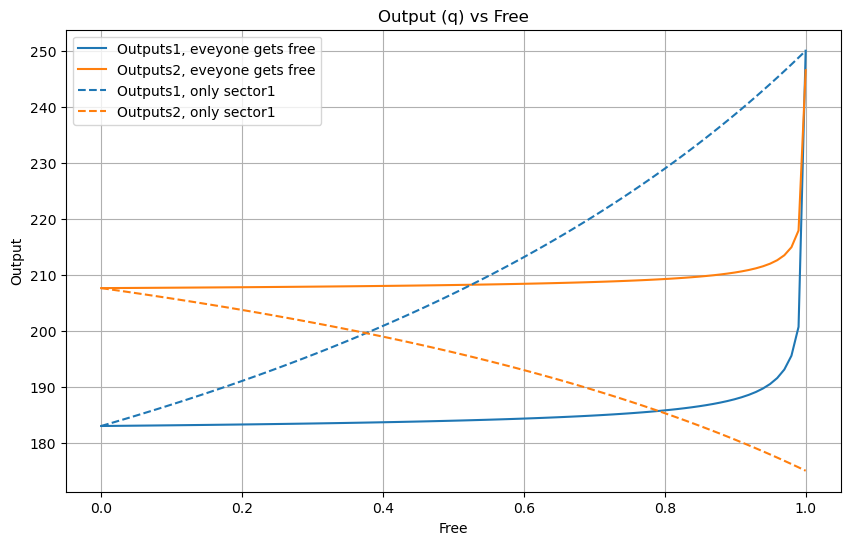

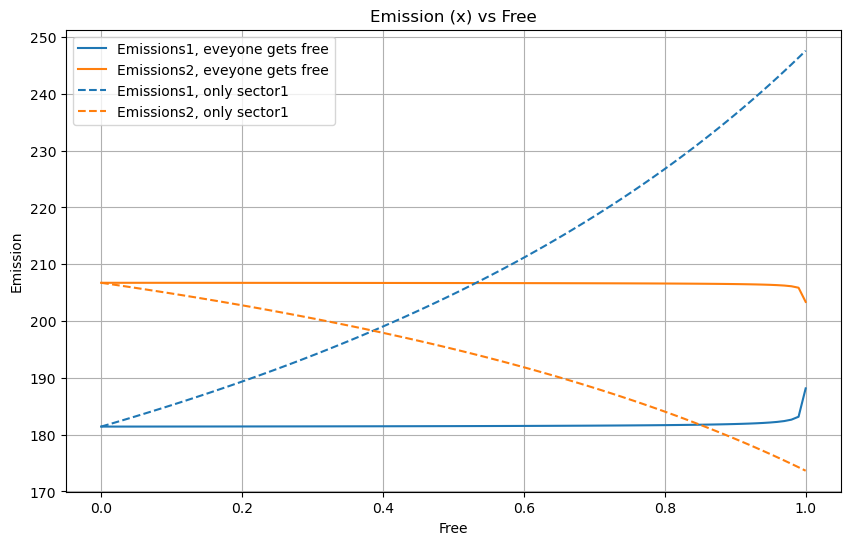

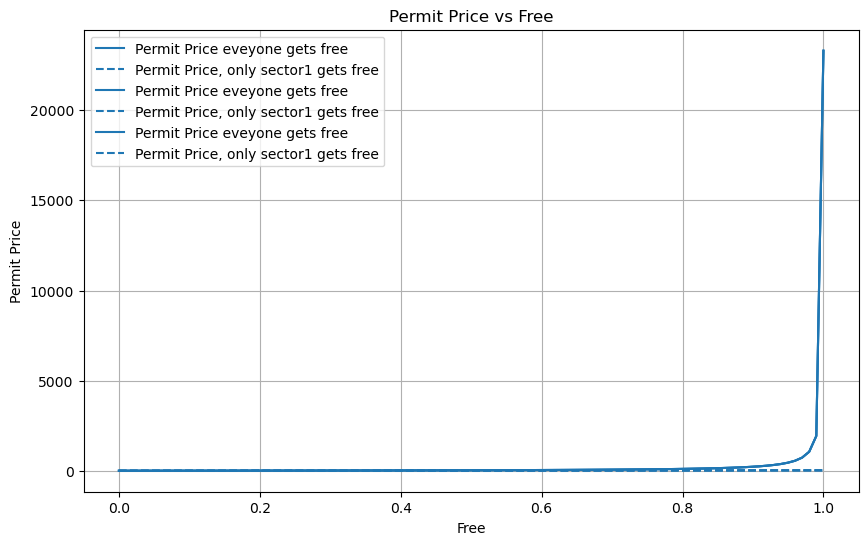

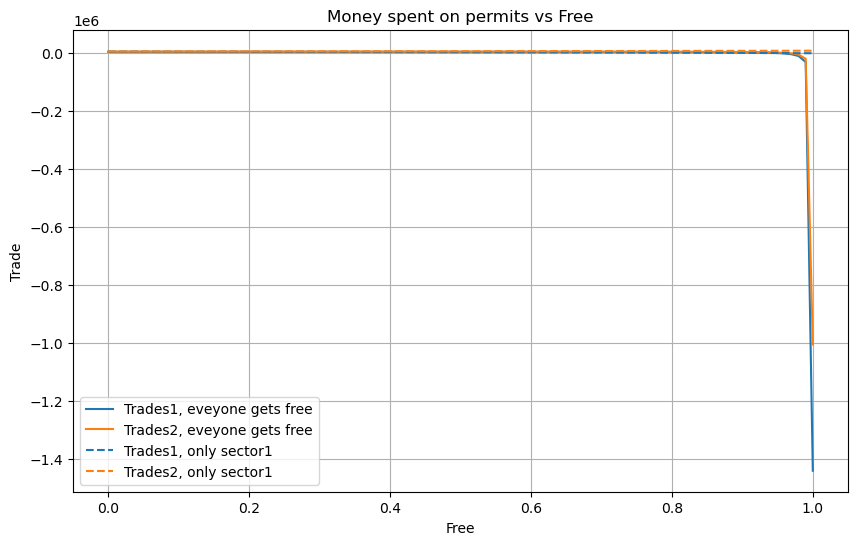

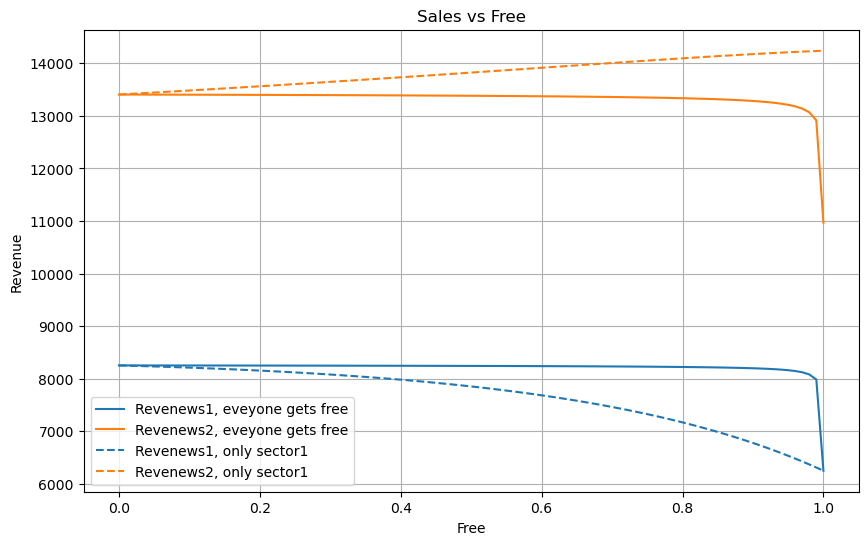

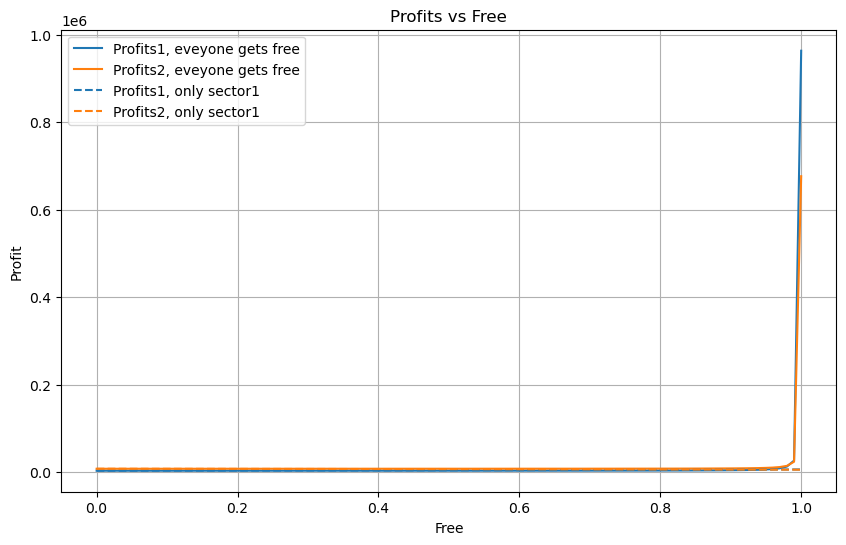

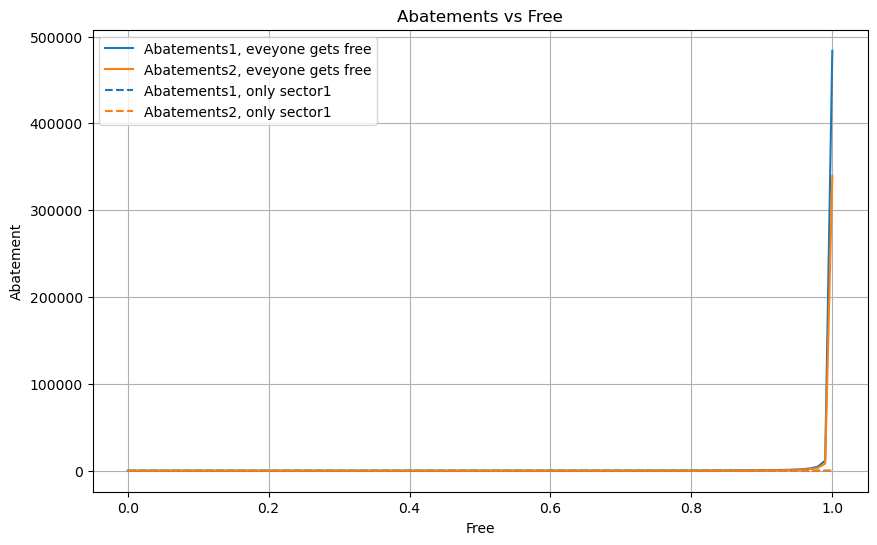

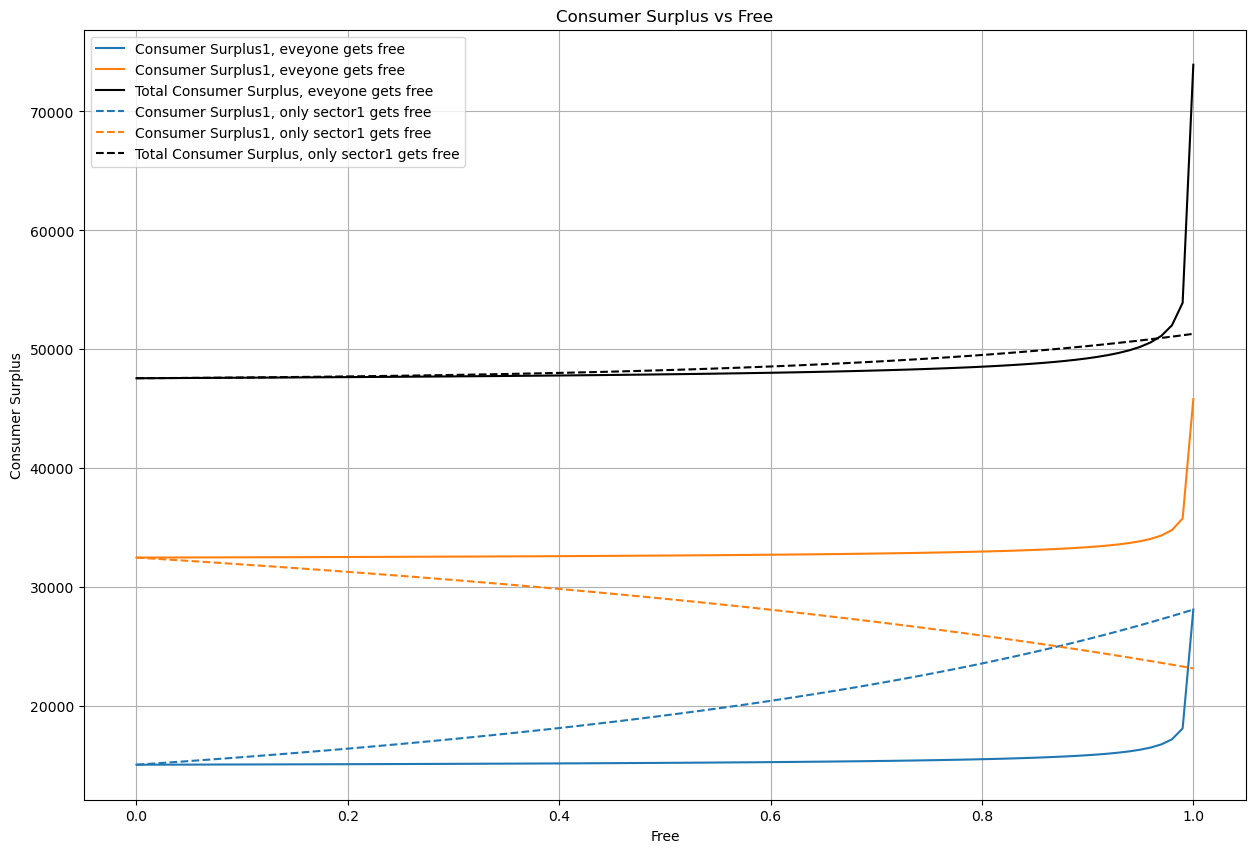

In [7]:
# Define colors and transparency levels
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}


# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label=f'{metric.capitalize()}1, eveyone gets free', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label=f'{metric.capitalize()}2, eveyone gets free', color=colors['trades2'])
    plt.plot(frees, results[False][f'{metric}1'], label=f'{metric.capitalize()}1, only sector1', color=colors['trades1'], linestyle='--')
    plt.plot(frees, results[False][f'{metric}2'], label=f'{metric.capitalize()}2, only sector1', color=colors['trades2'], linestyle='--')
    plt.xlabel('Free')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot consumer surplus


# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Free')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emission (x) vs Free')


# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Free')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Free')



# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Free')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatements vs Free')


from operator import add
plt.figure(figsize=(15, 10))
plt.plot(frees, results[True]['consumer_surplus_1'], label=f'Consumer Surplus1, eveyone gets free', color=colors['trades1'])
plt.plot(frees, results[True]['consumer_surplus_2'], label=f'Consumer Surplus1, eveyone gets free', color=colors['trades2'])
plt.plot(frees, list( map(add,results[True]['consumer_surplus_1'], results[True]['consumer_surplus_2'])), label=f'Total Consumer Surplus, eveyone gets free', color='black')
plt.plot(frees, results[False]['consumer_surplus_1'], label=f'Consumer Surplus1, only sector1 gets free', color=colors['trades1'], linestyle='--')
plt.plot(frees, results[False]['consumer_surplus_2'], label=f'Consumer Surplus1, only sector1 gets free', color=colors['trades2'], linestyle='--')
plt.plot(frees, list( map(add,results[False]['consumer_surplus_1'], results[False]['consumer_surplus_2'])), label=f'Total Consumer Surplus, only sector1 gets free', color='black', linestyle='--')
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Free')
plt.legend()
plt.grid()
plt.show()

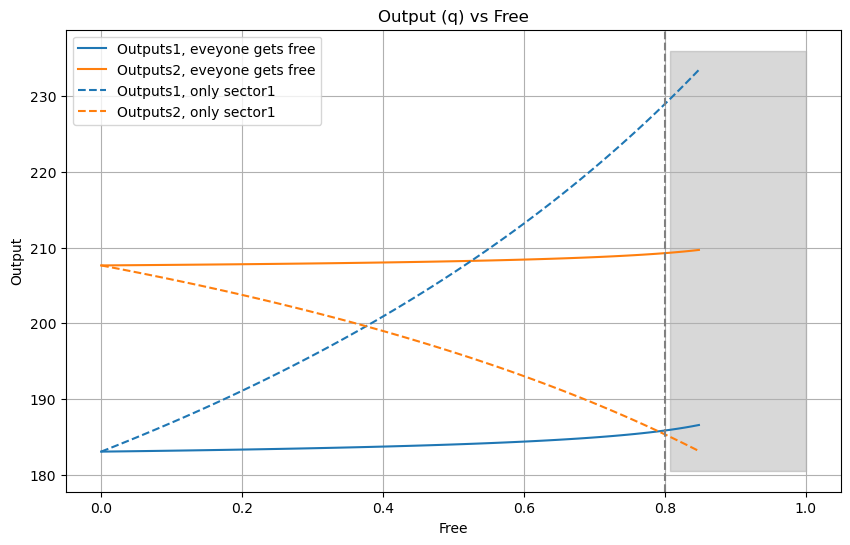

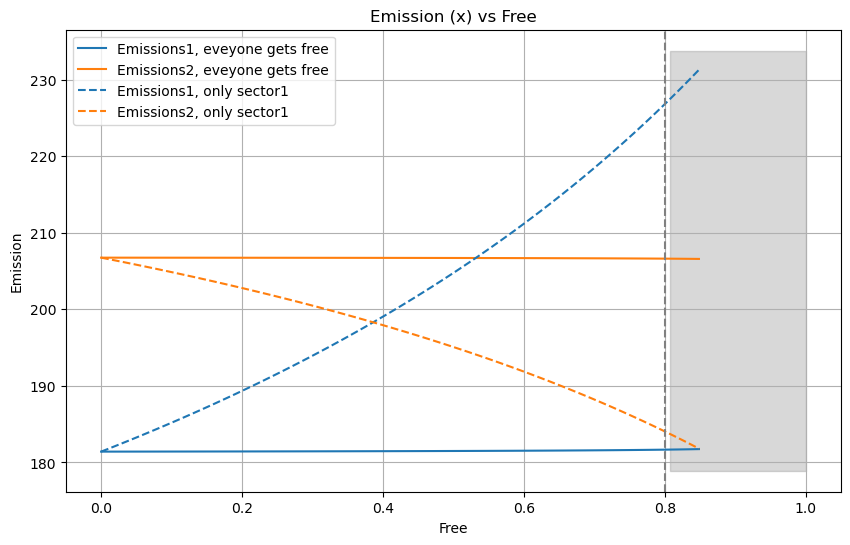

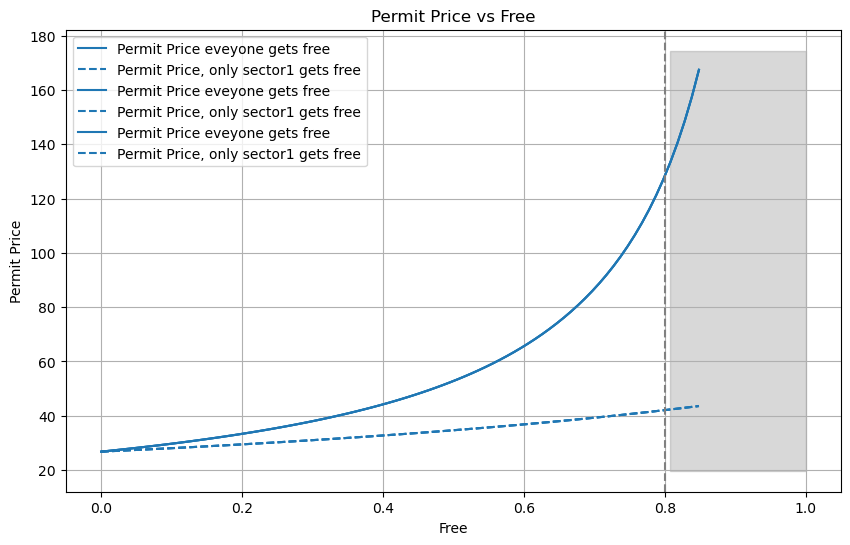

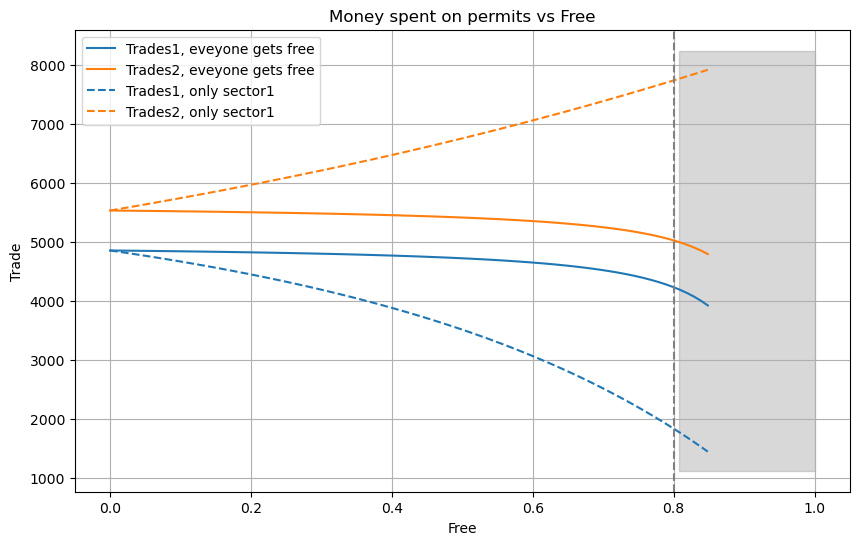

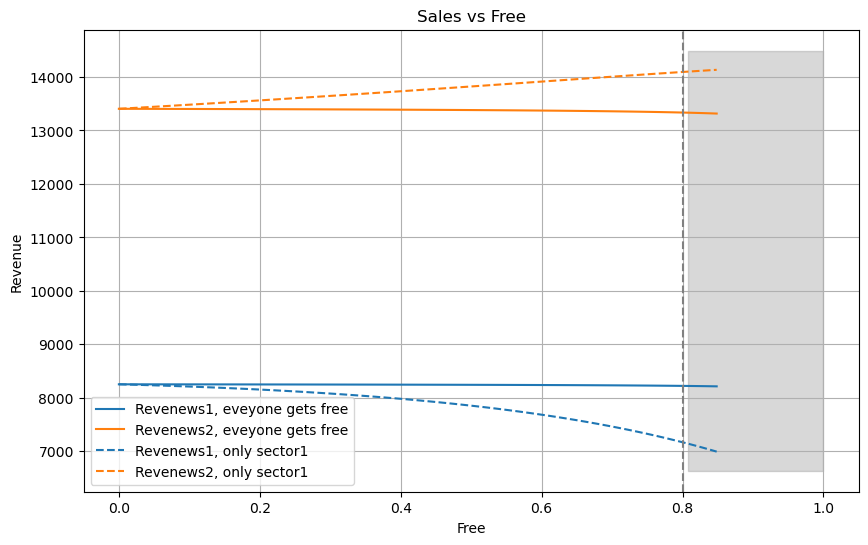

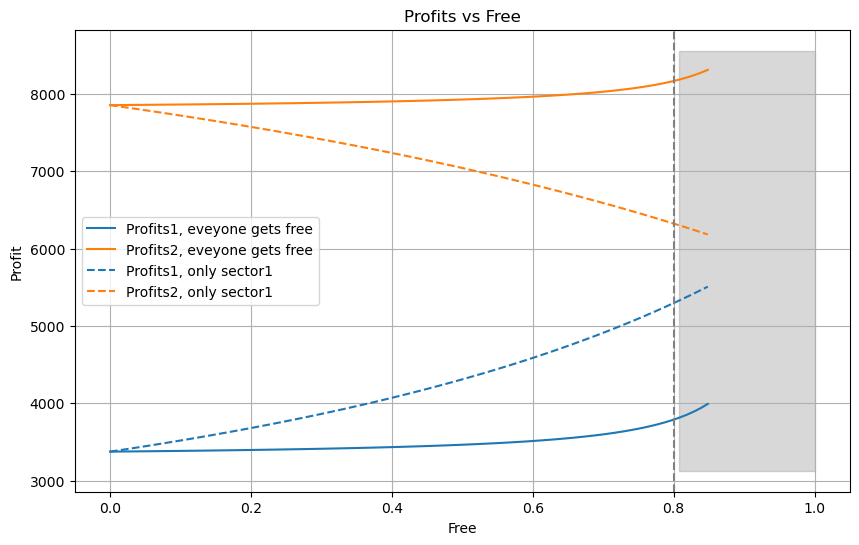

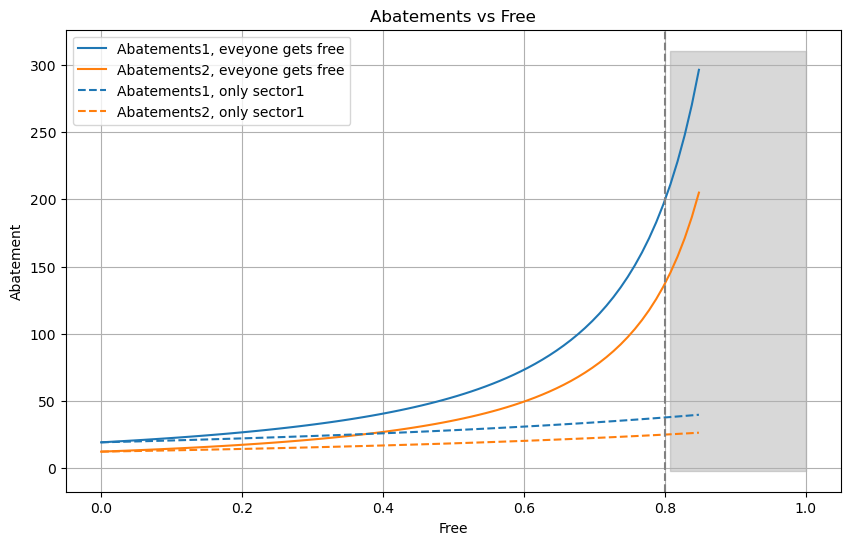

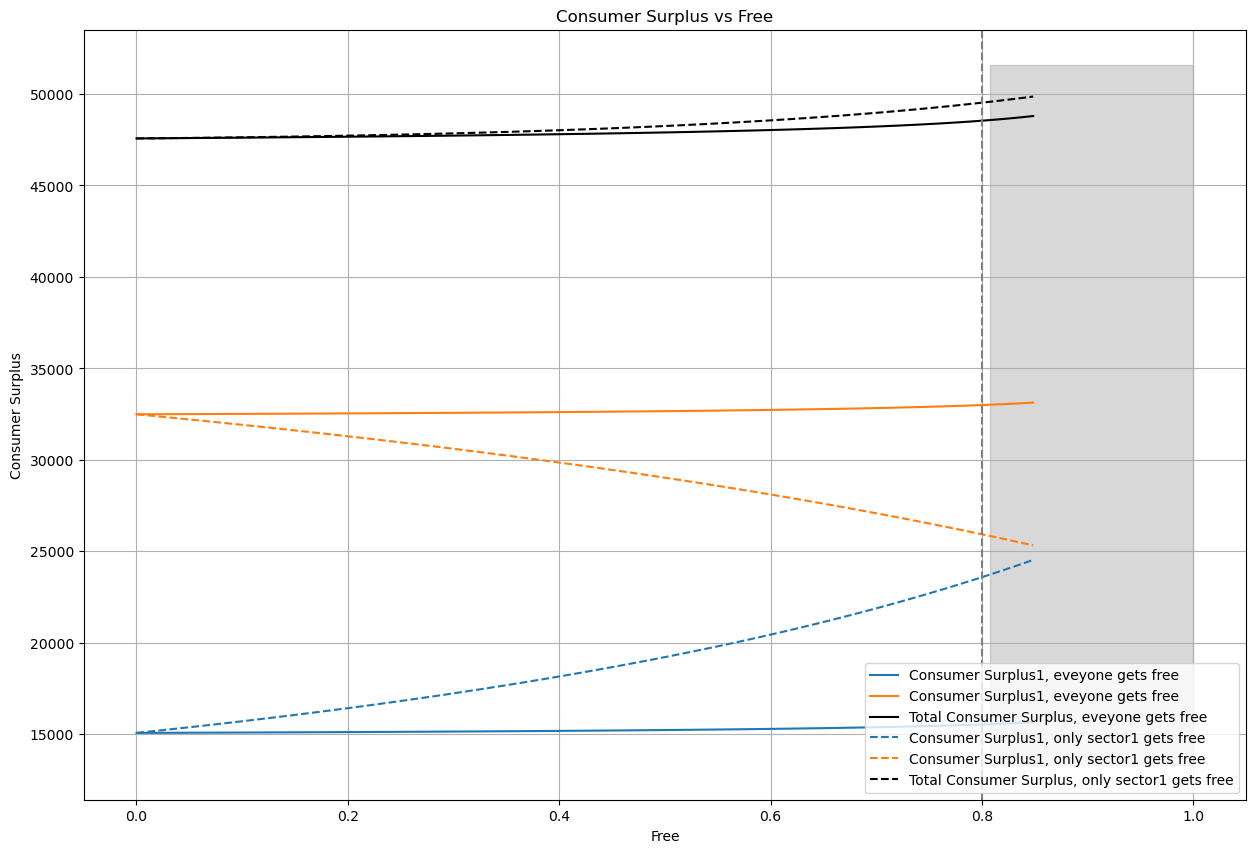

In [17]:
first_value = 0
last_value = 85
# Define colors and transparency levels
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}


# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees[first_value:last_value] , results[True][f'{metric}1'][first_value:last_value], label=f'{metric.capitalize()}1, eveyone gets free', color=colors['trades1'])
    plt.plot(frees[first_value:last_value], results[True][f'{metric}2'][first_value:last_value], label=f'{metric.capitalize()}2, eveyone gets free', color=colors['trades2'])
    plt.plot(frees[first_value:last_value], results[False][f'{metric}1'][first_value:last_value], label=f'{metric.capitalize()}1, only sector1', color=colors['trades1'], linestyle='--')
    plt.plot(frees[first_value:last_value], results[False][f'{metric}2'][first_value:last_value], label=f'{metric.capitalize()}2, only sector1', color=colors['trades2'], linestyle='--')
    plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
    plt.xlabel('Free')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot consumer surplus


# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Free')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emission (x) vs Free')

# Plot permit prices
plt.figure(figsize=(10, 6))
for do in [0.7, 0.8, 0.9]:
    plt.plot(frees[first_value:last_value], results[True]['permit_price'][first_value:last_value], label=f'Permit Price eveyone gets free', color=colors['trades1'])
    plt.plot(frees[first_value:last_value], results[False]['permit_price'][first_value:last_value], label=f'Permit Price, only sector1 gets free', color=colors['trades1'], linestyle='--')
plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Free')
plt.legend()
plt.grid()
plt.show()

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Free')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Free')



# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Free')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatements vs Free')


from operator import add
plt.figure(figsize=(15, 10))
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, eveyone gets free', color=colors['trades1'])
plt.plot(frees[first_value:last_value], results[True]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, eveyone gets free', color=colors['trades2'])
plt.plot(frees[first_value:last_value], list( map(add,results[True]['consumer_surplus_1'], results[True]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, eveyone gets free', color='black')
plt.plot(frees[first_value:last_value], results[False]['consumer_surplus_1'][first_value:last_value], label=f'Consumer Surplus1, only sector1 gets free', color=colors['trades1'], linestyle='--')
plt.plot(frees[first_value:last_value], results[False]['consumer_surplus_2'][first_value:last_value], label=f'Consumer Surplus1, only sector1 gets free', color=colors['trades2'], linestyle='--')
plt.plot(frees[first_value:last_value], list( map(add,results[False]['consumer_surplus_1'], results[False]['consumer_surplus_2']))[first_value:last_value], label=f'Total Consumer Surplus, only sector1 gets free', color='black', linestyle='--')
plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Consumer Surplus')
plt.title('Consumer Surplus vs Free')
plt.legend()
plt.grid()
plt.show()

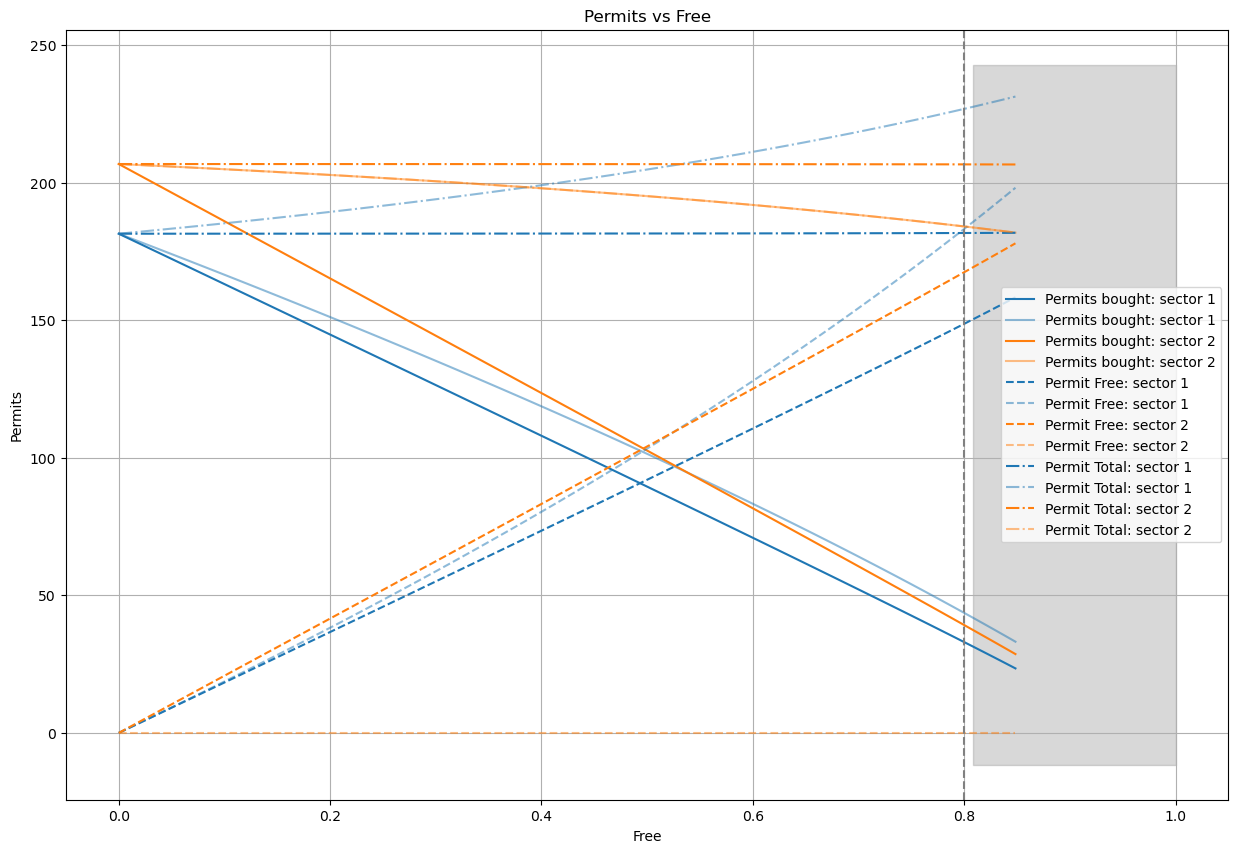

In [18]:


first_value = 0
last_value = 85
# Define colors and transparency levels
colors = {'b': '#1f77b4', 'o': '#ff7f0e'}
alphas = {True: 1, False: 0.5}

# Plot permits bought, free, and used for each doentage
plt.figure(figsize=(15, 10))
for do in [True, False]: plt.plot(frees[first_value:last_value], results[do]['permits_bought_1'][first_value:last_value], label=f'Permits bought: sector 1', color=colors['b'], alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_bought_2'][first_value:last_value], label=f'Permits bought: sector 2', color=colors['o'], alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_free_1'][first_value:last_value], label=f'Permit Free: sector 1', color=colors['b'], linestyle='--', alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_free_2'][first_value:last_value], label=f'Permit Free: sector 2', color=colors['o'], linestyle='--', alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_used_1'][first_value:last_value], label=f'Permit Total: sector 1', color=colors['b'], linestyle='-.', alpha=alphas[do])
for do in [True, False]:plt.plot(frees[first_value:last_value], results[do]['permits_used_2'][first_value:last_value], label=f'Permit Total: sector 2', color=colors['o'], linestyle='-.', alpha=alphas[do])
plt.axvline(x=percentage_of_emission_cap, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees > percentage_of_emission_cap), color='grey', alpha=0.3)
plt.xlabel('Free')
plt.ylabel('Permits')
plt.title('Permits vs Free')
plt.legend()
plt.grid()
plt.show()